# Welcome to USS 2022 Machine Learning Workshop!


 We have lots prepared for you, so sit tight and lets get started!

### Logistic Regression

In [ ]:
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np

from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
import sys

import matplotlib.pyplot as plt

First we will read in the data set using Panda's read_csv() function:

In [5]:
df = pd.read_csv("data/Iris.csv")


NameError: name 'pd' is not defined

In [6]:
df.info()

NameError: name 'df' is not defined

In [9]:
transport_df = pd.read_csv("data/transport.csv")

transport_df = transport_df.drop(columns=["date "])


Now we split the dataset into train and test sets:

In [10]:
train_df, test_df = train_test_split(transport_df, test_size=0.2)

X_train, y_train = (train_df.drop(columns=["Mode"]),
                   train_df["Mode"])

X_test, y_test = (test_df.drop(columns=["Mode"]),
                  test_df["Mode"])


Lets look at the dataset information:

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 50 to 35
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Mode          57 non-null     object
 1   Route         57 non-null     object
 2   week          57 non-null     int64 
 3   Ticket Price  57 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ KB


In [12]:
train_df.head()

,Mode,Route,week,Ticket Price
50,Plane,mumbai-chennai,3,1890
37,Plane,mumbai-Ahmedabad,2,4262
43,Train,mumbai-Ahmedabad,2,320
6,Train,mumbai-delhi,1,610
38,Plane,mumbai-Ahmedabad,3,1868


In [13]:
train_df.Route.unique()

array(['mumbai-chennai', 'mumbai-Ahmedabad', 'mumbai-delhi',
       'mumbai-Banglore', 'mumbai-hydrabad', 'mumbai-kollkatta'],
      dtype=object)

We can see that Route is a categorical variable. Therefore we need to transform this into dummy binary variables. 

number dummy variables = # categories - 1

How can we do this in python? 

We can use a column transformer! Lets apply one-hot-encoding method to encode the Route column, and scaling to the numeric columns. 

1. Specify the columns we want to apply transformations to

In [14]:
# specify numeric feats 

numeric_feats = [ 
    "week", 
    "Ticket Price",
]
# specify categorical features

cat_feat = ["Route"]

2. Use Skit-learn's columntransformer to ensure transformations happen to each column

In [15]:
ct = make_column_transformer(
    
      (
        StandardScaler(),
        numeric_feats,
      ),  
    (
        OneHotEncoder(handle_unknown="ignore"),
        cat_feat,
    ),  
    
)

Now we are ready to train our model! How do we ensure column transformation are applied without any info from the testing set leaking into the model? 

Use a pipeline! The pipeline can be used with any model. Here we are using logistic regression. After making the pipeline, you can call fit on it to build the model. We'll look at that later.

In [16]:
pipe_lr = make_pipeline(
    ct,
    LogisticRegression(max_iter = 10000)
)

Lets talk about logistic regression. Our goal here is to determine weather someone took a plane or train. We can use logistic regression for classification problems like this one. 

Logistic regression uses the training data to learn coefficients, which then can be used to calculate prediction probabilities of the each class using the sigmoid function. This allows us to calculate the predicted probability of someone taking the plane vs train based on their data. 

**Pros of logistic regression:**

    1. easy to interpret: - predicted coeffecients give us info about feature importance and direction 
    
    2. low variance model - less likely to overfit than other models such as tree based models

### Hyperparamter Optimization

hyperparamters are used to tune the model during learning. Logistic Regresion model in skit-learn has a hyperparameter called C which is used to control the fundatamental tradeoff of bias and variance, to reduce the likeliness of the model overfitting or underfitting. Larger values of C increase change of overfitting and small values of C increase chance of underfitting 

lets try optimizing the hyperparamter C:

In [17]:
train_scores = []
cv_scores = []

C = 10.0 ** np.arange(-1.5, 2, 0.5)

for c in C:
    
    pipe_lr = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=c),
    )
    
    results = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
    
    train_scores.append(results["train_score"].mean())
    cv_scores.append(results["test_score"].mean())
    

scores = pd.DataFrame({"C": C, "Train Scores": train_scores, "CV Scores": cv_scores })

scores

,C,Train Scores,CV Scores
0,0.031623,0.938357,0.898485
1,0.100000,0.991111,0.966667
2,0.316228,1.000000,0.983333
3,1.000000,1.000000,1.000000
4,3.162278,1.000000,1.000000
5,10.000000,1.000000,1.000000
6,31.622777,1.000000,1.000000


Now lets fit the model: 

In [18]:
model = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=0.1),
    )

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['week', 'Ticket Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Route'])])),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

After fitting the model, we can predict on the testing set, and then print the results in a classification report. 

In [43]:
predict = model.predict(X_test)

res = classification_report(
        y_test, predict
    )

print(res)


              precision    recall  f1-score   support

       Plane       1.00      1.00      1.00         8
       Train       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



1.0


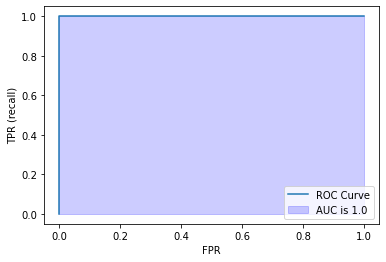

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# prediction probabilities on test set 
lr_prob = model.predict_proba(X_test)[:,1]

#y_test = y_test.map({'Train': 1, '': 0}).astype(int)

# roc_auc score on test set 
roc_lr = roc_auc_score(y_test, lr_prob)

fpr, tpr, thresholds = roc_curve(y_test, lr_prob, pos_label= "Train")

roc_lr = round(roc_lr, 4)

auc_label = "AUC is " + str(roc_lr)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.fill_between(fpr, tpr, color='blue', alpha=0.2, label=auc_label)

plt.legend(loc="best");

print(roc_lr)

YAY! 100% accuracy!!!! This will never happen in the real world. The reason it happens here is because there is such a big price jump from train tickets to planes that the algorithm picks up on

now lets look at an example: 

In [20]:
input = X_test.iloc[[10]]
input

,Route,week,Ticket Price
13,mumbai-Banglore,2,5102


We can get the predicted probability like this:

In [21]:
print(model.classes_)
model.predict_proba(input)

['Plane' 'Train']


array([[0.85824077, 0.14175923]])

The ouput is the probability of each class. The model predicted that the probability of the input being a plane is 96%. We can also look at the hard prediction. 

In [22]:
model.predict(input)

array(['Plane'], dtype=object)

This predicts class = plane if the predicted probability for plane is over 0.5

### Decision Tree Model

In [2]:
pipe_tree = make_pipeline(
ct, 
DecisionTreeClassifier(max_depth = None) 
)

NameError: name 'make_pipeline' is not defined

In [28]:
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['week', 'Ticket Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Route'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [1]:
pred = pipe_tree.predict(X_test)

res = classification_report(
        y_test, predict
    )

print(res)


NameError: name 'pipe_tree' is not defined

## Random Forest Classifier

Random forests is a supervised learning algorithm that is comprised of decision trees. Although it can be used both for classification and regression, today we are mainly focus on how to create a random forest classifier using python. 

### What is the random forest algorithm?

Random forest is a popular supervised machine learning, based on the concept of ensemble learning (which means that multiple classifiers is used collectively to solve a problem). The random forest algorithm relies on multiple decision trees and then accepts the most-voted results from the predictions of each tree. 

Random forest classifiers have a plethora of applications in multiple domains. Some examples of Random Forest's applications are: Credit Card Fraud Detection, Diabetes Prediction, Breast Cancer Prediction, and Bitcoin Price Detection.

### How does the algorithm work?

It works in four steps:

1. Select random samples from a given dataset.
2. Construct a decision tree for each sample and get a prediction result from each decision tree.
3. Perform a vote for each predicted result.
4. Select the prediction result with the most votes as the final prediction.

In this workshop, you will be building a RF model on the iris flower data set. Iris flower data set is a very famous classification set. It comprises the sepal length, sepal width, petal length, petal width, and type of flowers. You can access the data set by importing the datasets library from scikit-learn, and load the iris dataset with `load_iris()`

### Let's Dive into Some Python Codes Now

Now we are building a model on the iris flower dataset. Start by importing the datasets library from `sklearn`, and load the iris data set.

In [1]:
from sklearn import datasets
#Load dataset
iris =  datasets.load_iris()

Let's print the target and feature variable names just to make sure that we are using the right dataset

In [2]:
print(iris.target_names)
print(iris.feature_names)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Now we create a dataframe of this iris dataset. Since the species of iris flower is what we are interested in classifying, we first separate columns accordingly into dependent and independent variables.   
Steps as follow:

In [8]:
import pandas as pd
data = pd.DataFrame({
    'sepal_length': iris.data[:,0],
    'sepal_width': iris.data[:,1],
    'petal_length': iris.data[:,2],
    'petal_width': iris.data[:,3],
    'species': iris.target
})

data.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [9]:
# Seperate cols to dependent and independent variables
y = data['species']
X = data[['sepal_length','sepal_width','petal_length','petal_width']]

We then use the `train_test_split` function to split variables into train and test set (Let's take 75% to training and 25% to testing), and train the model on the train set and perform predictions on the test set. Don't forget to import `RandomForestClassifier` from `sklearn.ensemble`

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)
    
# create the classifier
classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(X_train, y_train)
# make the prediction using the RF model
y_pred = classifier.predict(X_test)

We now examine the RF model's accuracy using the actual y (species) value and the predicted values given by the model.

In [22]:
from sklearn import metrics

print("The accuracy for RF model is: ", round(metrics.accuracy_score(y_test, y_pred),4))

The accuracy for RF model is:  0.9474


And we say the accuracy is pretty high for such model! To make a prediction on a single item, we can also use the `predict()` function.  
For example:  
    - sepal length = 3  
    - sepal width = 6  
    - petal length = 6  
    - petal width = 4  
Now we can predict which type of the iris flower it is as below.

In [24]:
classifier.predict([[3,6,6,4]])

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([2])

Here, the output is 2, which indicates an iris type of Virginica.

Congratulation! You have made it so far and know what a typical random forest classifier in python looks like. If you are interested in learning more about the random forest algorithm, we encourage you to browse through the internet as there are a lot more interesting readings and tutorials regarding the random forest waiting for you to discover!